In [22]:
# Importando as bibliotecas necessárias
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2025-06-06 00:47:20--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 2606:4700:3037::6815:589c, 2606:4700:3030::ac43:b9c7, 104.21.88.156, ...
Connecting to pjreddie.com (pjreddie.com)|2606:4700:3037::6815:589c|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data/mnist_train.csv.1’

mnist_train.csv.1       [ <=>                ]   8,88K  --.-KB/s    in 0s      

2025-06-06 00:47:21 (23,9 MB/s) - ‘data/mnist_train.csv.1’ saved [9093]



In [6]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [8]:
# Criando índices aleatórios para os subsets de treino e teste
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

train_indices = indices[:10000]  # Primeiros 10.000 índices para o trainset
test_indices = indices[10000:11000]  # Próximos 1.000 índices para o testset

trainset = Subset(mnist_dataset, train_indices)
testset = Subset(mnist_dataset, test_indices)

In [9]:
# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

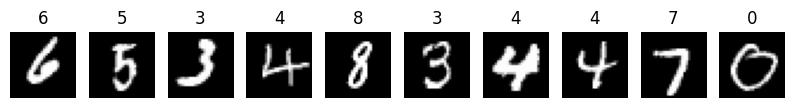

In [11]:
def show_batch(loader):
    images, labels = next(iter(loader))
    plt.figure(figsize=(10, 2))
    for i in range(10):
        img = images[i].squeeze().numpy() * 0.5 + 0.5  # desfaz a normalização
        plt.subplot(1, 10, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(labels[i].item())
        plt.axis('off')
    plt.show()

show_batch(testloader)

In [35]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 5),        # 28x28 → 24x24
            nn.ReLU(),
            nn.MaxPool2d(2),           # → 12x12
            nn.Conv2d(6, 12, 5),       # → 8x8
            nn.ReLU(),
            nn.MaxPool2d(2),            # → 4x4
            nn.Flatten(),                # Achata a saída para 1D
            nn.Linear(12 * 4 * 4, 64)   # Linear layer para reduzir a dimensionalidade
        )
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [36]:
model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [37]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Acc: {acc:.2f}%")

Epoch 1/5 - Loss: 126.1000 - Acc: 75.86%
Epoch 2/5 - Loss: 32.5590 - Acc: 93.92%
Epoch 3/5 - Loss: 22.4370 - Acc: 95.77%
Epoch 4/5 - Loss: 17.2932 - Acc: 96.65%
Epoch 5/5 - Loss: 15.0861 - Acc: 97.21%


In [38]:
model.eval()
embeddings = []
labels_list = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        x = model.encoder(images)
        embeddings.append(x.cpu())
        labels_list.append(labels)

X = torch.cat(embeddings).numpy()
y = torch.cat(labels_list).numpy()

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

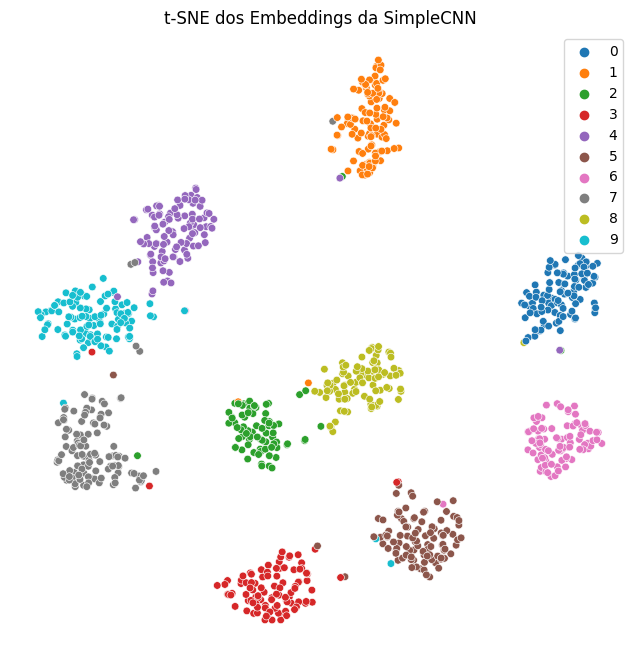

In [39]:
from sklearn.manifold import TSNE
import seaborn as sns


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10', s=30)
plt.title("t-SNE dos Embeddings da SimpleCNN")
plt.axis('off')
plt.show()

In [40]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

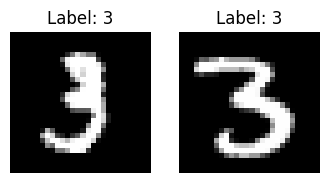

Distância euclidiana entre os embeddings: 14.2244


In [48]:
# Escolher duas imagens do dataset
idx1, idx2 = 10, 12
img1, label1 = mnist_dataset[idx1]
img2, label2 = mnist_dataset[idx2]

# Visualizar as imagens
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(img1.squeeze() * 0.5 + 0.5, cmap='gray')
plt.title(f"Label: {label1}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2.squeeze() * 0.5 + 0.5, cmap='gray')
plt.title(f"Label: {label2}")
plt.axis('off')
plt.show()

# Extrair embeddings com encoder
model.eval()
with torch.no_grad():
    emb1 = model.encoder(img1.unsqueeze(0).to(device)).cpu().numpy()[0]
    emb2 = model.encoder(img2.unsqueeze(0).to(device)).cpu().numpy()[0]

# Calcular distância
dist = euclidean_distance(emb1, emb2)
print(f"Distância euclidiana entre os embeddings: {dist:.4f}")